In [55]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


def plot_explained_variance(exp_var: np.ndarray, title: str, figname: str) -> None:
    exp_var_ratio = exp_var / np.sum(exp_var)
    cum_exp_var = np.cumsum(exp_var_ratio)
    plt.step(range(len(cum_exp_var)), cum_exp_var, where="mid", label="Cumulative Explained Variance")
    plt.bar(range(len(exp_var_ratio)), exp_var_ratio, alpha=0.5, align="center", label="Explained Variance")
    plt.xticks(range(len(exp_var_ratio)))
    plt.xlabel("Principal Component Index")
    plt.ylabel("Explained Variance")
    plt.legend()
    plt.title(title)
    plt.savefig(figname)
    plt.show()


def balanced_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr: float = tp / (tp + fn)
    tnr: float = tn / (tn + fp)
    ba = (tpr + tnr) / 2

    return ba

### 2.1. PCA

#### 2.1.1 Generate dataset

X.shape=(500, 3)
X.mean=[4.9965698  9.75278731 2.03891903]
X.cov=[[ 3.41152277  2.70367742  2.28965443]
 [ 2.70367742 11.00466003  1.50885921]
 [ 2.28965443  1.50885921  2.1773361 ]]


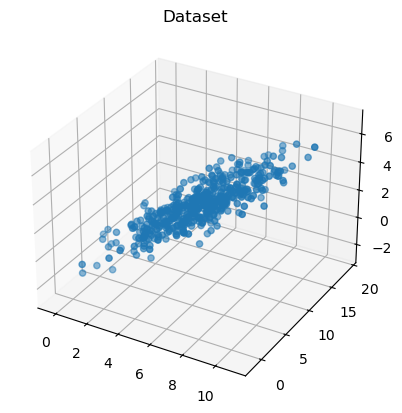

In [6]:
mean = np.array([5, 10, 2])
cov = np.array([[3, 2, 2], [2, 10, 1], [2, 1, 2]])
X = np.random.multivariate_normal(mean, cov, size=500)
print(f"X.shape={X.shape}")
print(f"X.mean={X.mean(axis=0)}")
print(f"X.cov={np.cov(X.T)}")

# Plot the 3D data
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
plt.title("Dataset")
plt.savefig("plots/2.1.1 Dataset.png")
plt.show()

#### 2.1.2 Explained Variance

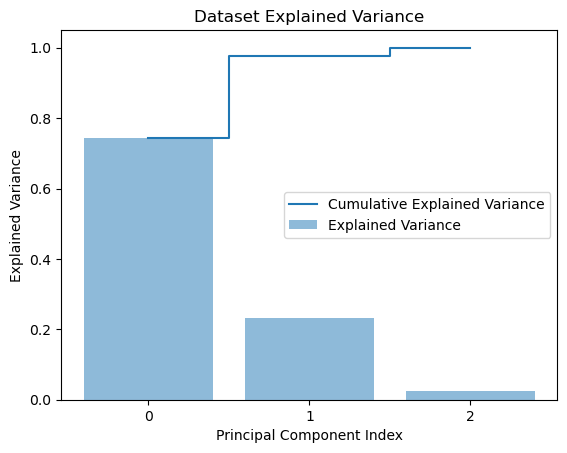

In [ ]:
N = len(X)
X_normed: np.ndarray = X - np.mean(X, axis=0)
sigma = X_normed.T @ X_normed / N
sigma_eigh = np.linalg.eigh(sigma)
P = np.vstack(sigma_eigh.eigenvectors)
D = np.diag(sigma_eigh.eigenvalues)
# Explained variance
sorted_indices = np.argsort(sigma_eigh.eigenvalues)[::-1]
sigma_eigenvalues = sigma_eigh.eigenvalues[sorted_indices]
exp_var = sigma_eigenvalues


# Step plot
plot_explained_variance(exp_var, title="Dataset Explained Variance", figname="plots/2.1.2 Explained Variance.png")

#### 2.1.3 Anomalies with respect to deviation

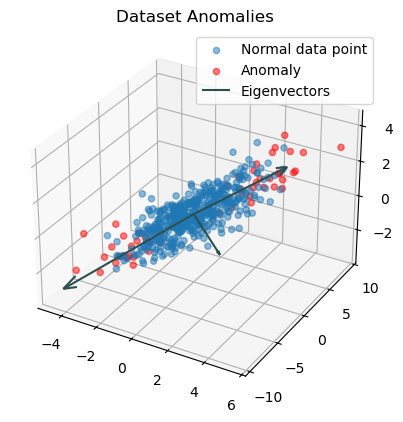

In [140]:
contamination: float = 0.1
# Find outliers in the projected space by distance over the dimension corresponding to the smallest eigenvalue
X_proj = X_normed @ P
dimension = 2
scores = np.abs(X_proj[:, dimension] - np.mean(X_proj[:, dimension]))
threshold = np.quantile(scores, 1 - contamination)
is_anomaly = scores > threshold
# Plot dataset with anomalies
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*X_normed[~is_anomaly].T, alpha=0.5, label="Normal data point")
ax.scatter(*X_normed[is_anomaly].T, color="red", alpha=0.5, label="Anomaly")
ax.quiver(
    *np.zeros((3, 3)),
    *P * (sigma_eigenvalues[::-1] ** 0.5),
    length=4,
    arrow_length_ratio=0.1,
    colors="darkslategrey",
    label="Eigenvectors"
)
plt.legend()
plt.title("Dataset Anomalies")
plt.savefig("plots/2.1.3 Anomalies.png")
plt.show()

#### 2.1.4 Anomalies with respect to normalized distance

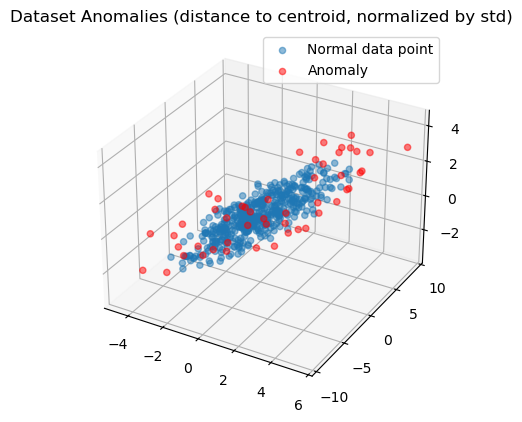

In [139]:
contamination: float = 0.1
# Find outliers in the projected space by normalized distance
scores = np.sum(np.power((X_proj - np.mean(X_proj)) / np.std(X_proj, axis=0), 2), axis=1)
threshold = np.quantile(scores, 1 - contamination)
is_anomaly = scores > threshold
# Plot dataset with anomalies
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*X_normed[~is_anomaly].T, alpha=0.5, label="Normal data point")
ax.scatter(*X_normed[is_anomaly].T, color="red", alpha=0.5, label="Anomaly")
plt.legend()
plt.title("Dataset Anomalies (distance to centroid, normalized by std)")
plt.savefig("plots/2.1.4 Anomalies.png")
plt.show()

### 2.2 PCA on Shuttle Dataset

In [ ]:
from pyod.models.kpca import KPCA
from pyod.models.pca import PCA
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#### 2.2.1 PCA on shuttle dataset

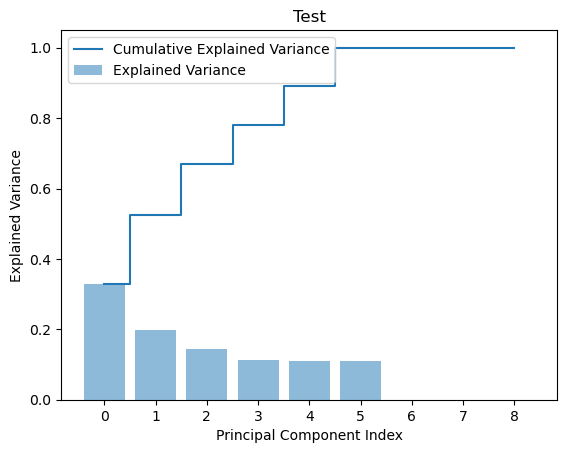

In [5]:
# Load data
data = loadmat("shuttle.mat")
X: np.ndarray = data["X"]
y: np.ndarray = data["y"]
# Split into train and test
X_train: np.ndarray = None
X_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)
# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# Fit data into PCA
contamination_train = np.sum(y_train) / len(y_train)
pca = PCA(contamination=contamination_train)
pca.fit(X_train)
# Plot explained variance
plot_explained_variance(pca.explained_variance_, title="Test", figname="plots/2.2.1 Explained Variance.png")

#### 2.2.2 Balanced Accuracy

In [ ]:
preds_pca_train = pca.predict(X_train)
preds_pca_test = pca.predict(X_test)
ba_pca_train = balanced_accuracy(y_true=y_train, y_pred=preds_pca_train)
ba_pca_test = balanced_accuracy(y_true=y_test, y_pred=preds_pca_test)
print(f"### PCA:\nTrain BA: {ba_pca_train:.6f}\nTest BA:  {ba_pca_test:.6f}")

run_kpca = False
if run_kpca:
    kpca = KPCA(contamination=contamination_train, kernel="linear")
    kpca.fit(X_train)
    preds_kpca_train = kpca.predict(X_train)
    preds_kpca_test = kpca.predict(X_test)
    ba_kpca_train = balanced_accuracy(y_true=y_train, y_pred=preds_kpca_train)
    ba_kpca_test = balanced_accuracy(y_true=y_test, y_pred=preds_kpca_test)
    print(f"\n### KPCA:\nTrain BA: {ba_kpca_train:.6f}\nTest BA:  {ba_kpca_test:.6f}")

### PCA:
Train BA: 0.974453
Test BA:  0.973134


### 2.3 Autoencoder

In [26]:
import keras
from keras import layers
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

#### 2.3.1 Load Data

In [51]:
# Load data
data = loadmat("shuttle.mat")
X: np.ndarray = data["X"]
y: np.ndarray = data["y"]
# Split into train and test
X_train: np.ndarray = None
X_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
contamination = (np.sum(y_train) + np.sum(y_test)) / (len(y_train) + len(y_test))

#### 2.3.2 Create Model

In [20]:
encoder = keras.Sequential(
    [layers.Dense(8, activation="relu"), layers.Dense(5, activation="relu"), layers.Dense(3, activation="relu")]
)
decoder = keras.Sequential(
    [layers.Dense(5, activation="relu"), layers.Dense(8, activation="relu"), layers.Dense(9, activation="sigmoid")]
)
autoencoder = keras.Sequential([encoder, decoder])

#### 2.3.3 Train Autoencoder

Epoch 0: train_loss=0.047373 val_loss=0.492386
Epoch 1: train_loss=0.037186 val_loss=0.466943
Epoch 2: train_loss=0.029988 val_loss=0.449803
Epoch 3: train_loss=0.024778 val_loss=0.431317
Epoch 4: train_loss=0.020732 val_loss=0.420627
Epoch 5: train_loss=0.017411 val_loss=0.411890
Epoch 6: train_loss=0.014749 val_loss=0.402549
Epoch 7: train_loss=0.012801 val_loss=0.398474
Epoch 8: train_loss=0.011400 val_loss=0.391042
Epoch 9: train_loss=0.010402 val_loss=0.381238
Epoch 10: train_loss=0.009680 val_loss=0.378315
Epoch 11: train_loss=0.009128 val_loss=0.369854
Epoch 12: train_loss=0.008385 val_loss=0.358402
Epoch 13: train_loss=0.007869 val_loss=0.349564
Epoch 14: train_loss=0.007523 val_loss=0.343305
Epoch 15: train_loss=0.007237 val_loss=0.338066
Epoch 16: train_loss=0.006988 val_loss=0.332700
Epoch 17: train_loss=0.006771 val_loss=0.329414
Epoch 18: train_loss=0.006580 val_loss=0.323504
Epoch 19: train_loss=0.006407 val_loss=0.319835
Epoch 20: train_loss=0.006254 val_loss=0.315752
Ep

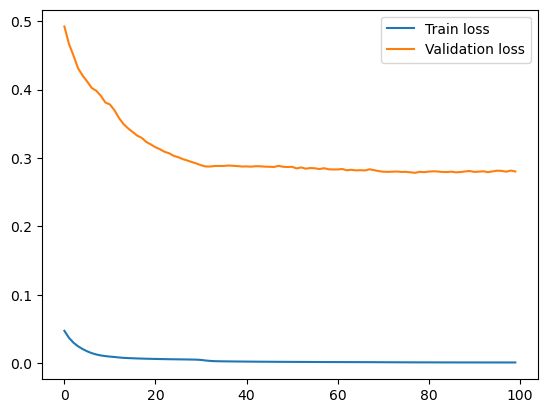

In [42]:
def val_loss(model: keras.Sequential, loss: keras.losses.Loss, val_dataset: tf.data.Dataset) -> float:
    val_losses: list[float] = []
    for X_val_batch, y_val_batch in val_dataset:
        preds_val_batch = model(X_val_batch)
        val_loss = loss(y_val_batch, preds_val_batch)
        val_losses.append(val_loss)

    return np.mean(val_losses)


epochs = 100
batch_size = 1024
# Create model
optimizer = keras.optimizers.Adam()
loss = keras.losses.MeanSquaredError()
autoencoder.compile(optimizer=optimizer, loss=loss)
# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = val_dataset.shuffle(buffer_size=len(X_test)).batch(batch_size)
# Train loop
train_losses: list[float] = []
val_losses: list[float] = []
for epoch in range(epochs):
    epoch_train_losses: list[float] = []
    for idx, (X_train_batch, _) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            preds_train_batch = autoencoder(X_train_batch, training=True)
            train_loss = loss(X_train_batch, preds_train_batch)
        grads = tape.gradient(train_loss, autoencoder.trainable_weights)
        optimizer.apply(grads, autoencoder.trainable_weights)
        epoch_train_losses.append(train_loss)
    train_losses.append(np.mean(epoch_train_losses))
    val_losses.append(val_loss(autoencoder, loss, val_dataset))
    print(f"Epoch {epoch}: train_loss={train_losses[-1]:.6f} val_loss={val_losses[-1]:.6f}")
# Plot losses
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.savefig("plots/2.2.3 Losses.png")
plt.show()

#### 2.2.4 Anomaly Scores

In [56]:
def compute_losses(model: keras.Sequential, dataset: tf.data.Dataset) -> list:
    losses_batches: list[tf.Tensor] = []
    for X_batch, _ in dataset:
        preds_batch: tf.Tensor = model(X_batch)
        loss_batch = keras.losses.mean_squared_error(X_batch, preds_batch)
        losses_batches.append(loss_batch)

    return tf.concat(losses_batches, axis=0)


train_losses = compute_losses(autoencoder, train_dataset)
train_threshold = np.quantile(train_losses, q=1 - contamination)
train_preds = train_losses > train_threshold
train_ba = balanced_accuracy(y_train, train_preds)
print(f"Train BA: {train_ba:.6f}")
test_losses = compute_losses(autoencoder, val_dataset)
test_threshold = np.quantile(test_losses, q=1 - contamination)
test_preds = test_losses > test_threshold
test_ba = balanced_accuracy(y_test, test_preds)
print(f"Test BA:  {test_ba:.6f}")

Train BA: 0.497937
Test BA:  0.504429
